In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [2]:
using ArviZ
using Bump10MSun
using DimensionalData
using Distributions
using HDF5
using LaTeXStrings
using Printf
using MCMCChains
using MCMCChainsStorage
using MCMCDiagnosticTools
using StatsBase
using StatsPlots
using Trapz

Here we are fitting 
$$
\frac{\mathrm{d} N}{\mathrm{d} m_1 \mathrm{d} m_2 \mathrm{d} V \mathrm{d} t} = \frac{R}{m_1 m_2} g\left( q \right) f\left( m_1 \right) f\left( m_2 \right)
$$
where the "common" mass function
$$
f\left( m \right) = \begin{cases}
\left( \frac{m}{m_{b,12}} \right)^{\alpha_1} & m < m_{b,12} \\
\left( \frac{m}{m_{b,12}}\right)^{\alpha_2} & m_{b,12} < m < m_{b,23} \\
\left( \frac{m}{m_{b,12}} \right)^{\alpha_3} \left( \frac{m_{b,23}}{m_{b,12}} \right)^{\alpha_2 - \alpha_3} & m \geq m_{b,23}
\end{cases}
$$
and the "pairing" function is a power law in mass ratio:
$$
g\left( q \right) = q^\beta
$$
for 
$$
3 \, M_\odot < m_2 < m_1 < 20 \, M_\odot.
$$
Note: the definition above implies that $R$ is the volumetric merger rate per log mass squared at $m_1 = m_2 = m_{b,12}$.

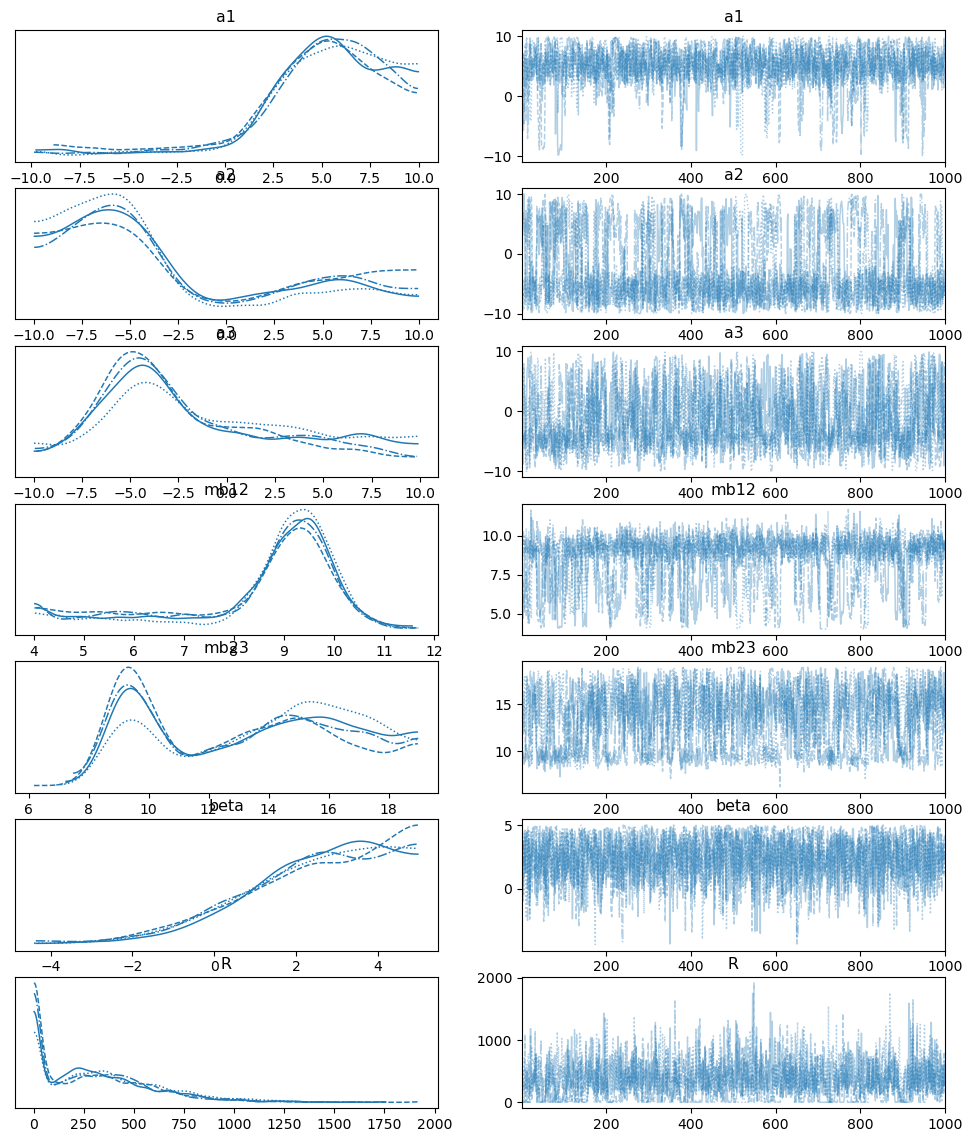

7×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ a1          5.119    3.332    0.025    9.995      0.121    0.086    101 ⋯
   2 │ a2         -3.025    5.719   -9.998    7.878      0.324    0.229     42
   3 │ a3         -1.499    4.886   -9.401    7.845      0.199    0.141     69
   4 │ mb12        8.548    1.644    4.481   10.506      0.091    0.064     43
   5 │ mb23       13.309    3.225    8.456   18.472      0.192    0.136     33 ⋯
   6 │ beta        2.46     1.766   -0.585    4.998      0.035    0.031    219
   7 │ R         339.013  284.408    0.0    824.13      11.496    8.133     46
                                                               3 columns omitted

In [3]:
trace = from_netcdf(joinpath(@__DIR__, "..", "chains", "chain_tb_plp.nc"))
var_names = map(String, [:a1, :a2, :a3, :mb12, :mb23, :beta, :R])
plot_trace(trace, var_names=var_names)
summarystats(trace, var_names=var_names)

In [4]:
post = trace.posterior
all_vars_post = map(k -> post[k], [:a1, :a2, :a3, :mb12, :mb23, :beta, :R])
dNdm1dm2 = map(all_vars_post...) do a1, a2, a3, mb12, mb23, beta, R
    ldN = make_log_dN(a1, a2, a3, mb12, mb23, beta)
    (m1, m2) -> R*exp(ldN(m1,m2))
end
dNdm1 = map(all_vars_post...) do a1, a2, a3, mb12, mb23, beta, R
    dN = make_dNdm1(a1, a2, a3, mb12, mb23, beta)
    m1 -> R*dN(m1)
end
dNdm2 = map(all_vars_post...) do a1, a2, a3, mb12, mb23, beta, R
    dN = make_dNdm2(a1, a2, a3, mb12, mb23, beta)
    m2 -> R*dN(m2)
end
dNdq = map(all_vars_post...) do a1, a2, a3, mb12, mb23, beta, R
    dN = make_dNdq(a1, a2, a3, mb12, mb23, beta)
    q -> R*dN(q)
end
dNdm_pl = map(all_vars_post...) do a1, a2, a3, mb12, mb23, beta, R
    dN = make_dNdm(a1, a2, a3, mb12, mb23)
    m -> R*dN(m)
end
pprob = map(post.beta) do beta
    pf = make_pairing_prob(beta)
    q -> pf(q)
end;

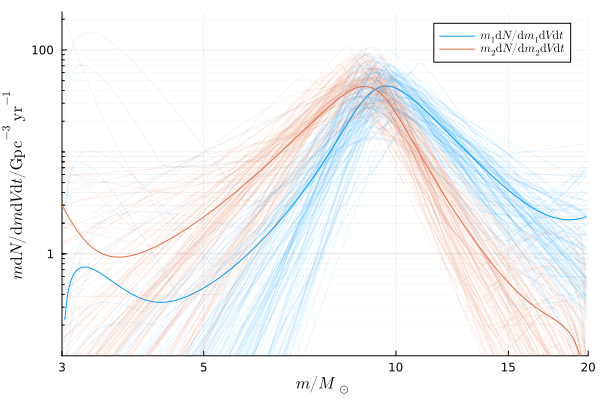

In [5]:
ms = exp.(log(mlow):0.01:log(mhigh))
dN1_mean = zeros(length(ms))
dN2_mean = zeros(length(ms))

p = plot(xlabel=L"m / M_\odot", ylabel=L"m \mathrm{d} N / \mathrm{d}m \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3}\, \mathrm{yr}^{-1}", minorgrid=true, yscale=:log10, ylims=(0.1, Inf), xscale=:log10, xlims=(3, 20), xticks=[3, 5, 10, 15, 20], formatter=(x->@sprintf("%g", x)))

for dN in dNdm1
    dN1_mean = dN1_mean .+ dN.(ms)
end
dN1_mean = dN1_mean ./ length(dNdm1)
p = plot!(ms, ms.*dN1_mean, label=L"m_1 \mathrm{d}N/\mathrm{d}m_1\mathrm{d}V\mathrm{d}t")
for _ in 1:100
    p = plot!(ms, ms.*sample(dNdm1).(ms), color=1, alpha=0.1, label=nothing)
end

for dN in dNdm2
    dN2_mean = dN2_mean .+ dN.(ms)
end
dN2_mean = dN2_mean ./ length(dNdm1)
p = plot!(ms, ms.*dN2_mean, color=2, label=L"m_2 \mathrm{d}N/\mathrm{d}m_2 \mathrm{d}V\mathrm{d}t")
for _ in 1:100
    p = plot!(ms, ms.*sample(dNdm2).(ms), color=2, alpha=0.1, label=nothing)
end

p

How about the "common" part of the mass function?

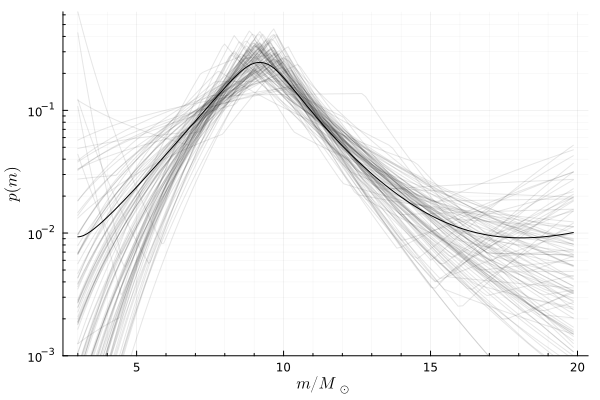

In [6]:
p = plot(xlabel=L"m/M_\odot", ylabel=L"p(m)", yscale=:log10, minorgrid=true, ylims=(1e-3, Inf))
dN_mean = zeros(length(ms))

for dN in dNdm_pl
    dN_mean = dN_mean .+ dN.(ms)
end
dN_mean = dN_mean ./ length(dNdm_pl)
dN_mean = dN_mean ./ trapz(ms, dN_mean)

p = plot!(ms, dN_mean, color=:black, label=nothing)
for _ in 1:100
    pp = sample(dNdm_pl).(ms)
    pp = pp ./ trapz(ms, pp)
    p = plot!(ms, pp, color=:black, alpha=0.1, label=nothing)
end
p

It is interesting to ask about properties of the *peak* itself---here are its first and second moments:

In [7]:
mus = Float64[]
sigmas = Float64[]
for dN in dNdm_pl
    pm = dN.(ms)
    pm = pm / trapz(ms, pm)

    mu = trapz(ms, ms .* pm)
    push!(mus, mu)

    v = trapz(ms, (ms .- mu).^2 .* pm)
    push!(sigmas, sqrt(v))
end

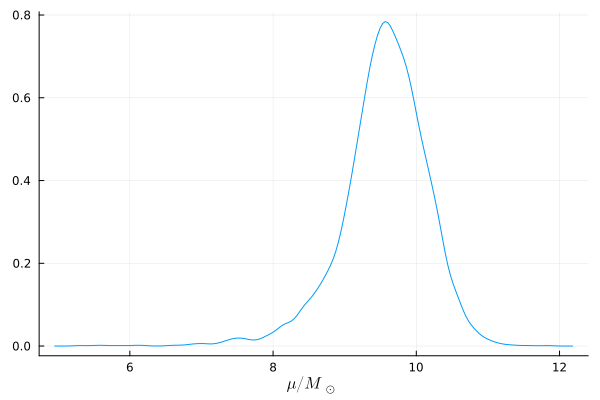

In [8]:
density(mus, label=nothing, xlabel=L"\mu / M_\odot")

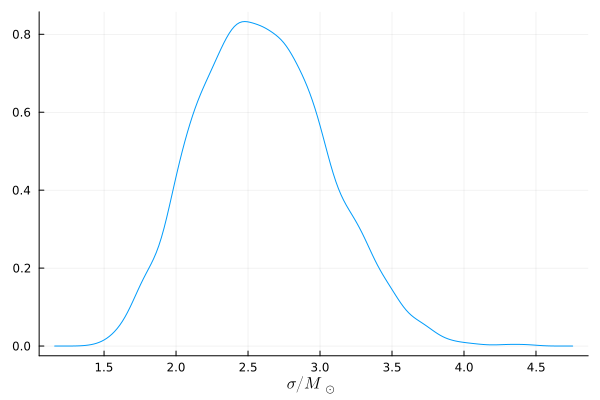

In [9]:
density(sigmas, label=nothing, xlabel=L"\sigma / M_\odot")

It looks like the peak has about 25% fractional width.

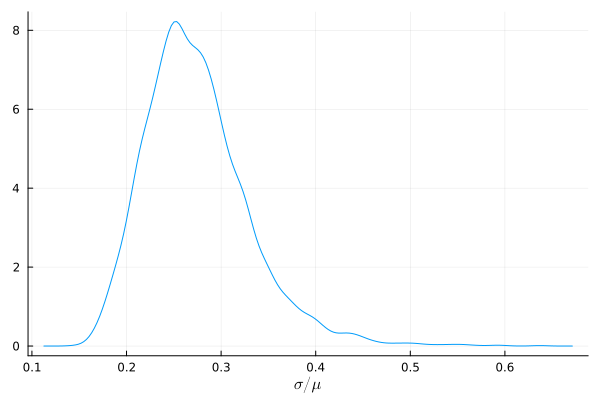

In [10]:
density(sigmas ./ mus, label=nothing, xlabel=L"\sigma / \mu")

Let's look at $\mathrm{d} N/\mathrm{d} q$:

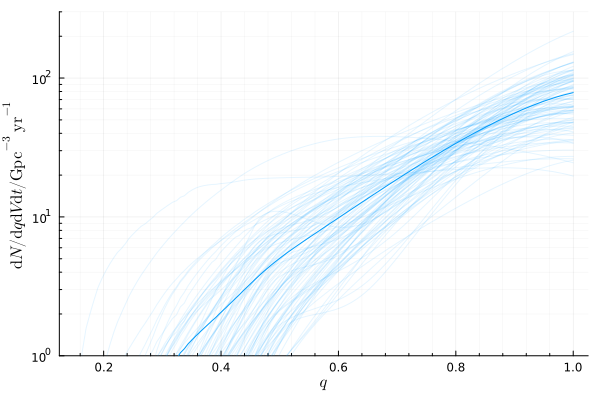

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/rz1WP/src/utils.jl:106


In [11]:
qs = collect(range(mlow/mhigh, stop=1, length=128))
dNdq_mean = zeros(length(qs))

for dN in dNdq
    dNdq_mean .= dNdq_mean .+ dN.(qs)
end
dNdq_mean .= dNdq_mean ./ length(dNdq)
p = plot(qs, dNdq_mean, color=1, yscale=:log10, ylims=(1e0, 3e2), legend=nothing, minorgrid=true, xlabel=L"q", ylabel=L"\mathrm{d}N/\mathrm{d}q\mathrm{d}V\mathrm{d}t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}")

for _ in 1:100
    p = plot!(qs, sample(dNdq).(qs), color=1, alpha=0.1)
end

p

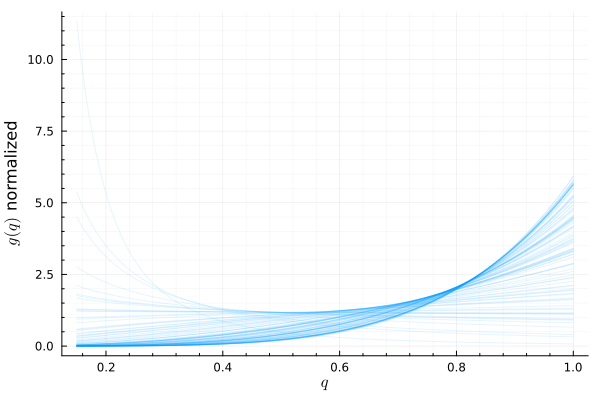

In [12]:
pp = plot(xlabel=L"q", ylabel=L"$g(q)$ normalized", legend=nothing, minorgrid=true)
for _ in 1:100
    p = sample(pprob)
    pb = p.(qs)
    pb /= trapz(qs, pb)
    pp = plot!(qs, pb, color=1, alpha=0.1, label=nothing)
end
pp

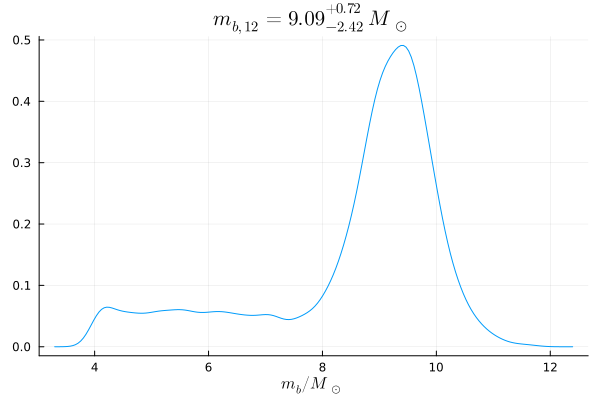

In [13]:
x = vec(trace.posterior[:mb12])
l = quantile(x, 0.16)
m = quantile(x, 0.5)
h = quantile(x, 0.84)

p = density(x, xlabel=L"m_b / M_\odot", label=nothing)
p = title!(@sprintf("\$m_{b,12} = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l))

p

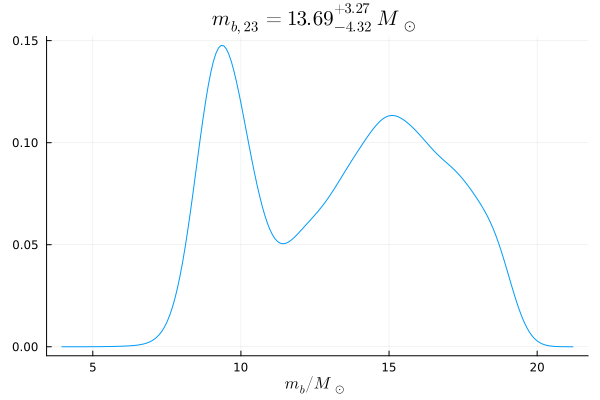

In [14]:
x = vec(trace.posterior[:mb23])
l = quantile(x, 0.16)
m = quantile(x, 0.5)
h = quantile(x, 0.84)

density(x, xlabel=L"m_b / M_\odot", label=nothing)
p = title!(@sprintf("\$m_{b,23} = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l))

p

It looks like one of the peaks is at $9 \, M_\odot$; let's pull that out, and also the other one:

In [15]:
xx = map(trace.posterior[:mb12], trace.posterior[:mb23]) do mb12, mb23
    d12 = abs(mb12 - 9.25)
    d23 = abs(mb23 - 9.25)

    if d12 < d23
        mb12, mb23
    else
        mb23, mb12
    end
end
mb_9 = map(x -> x[1], xx)
mb_other = map(x -> x[2], xx);

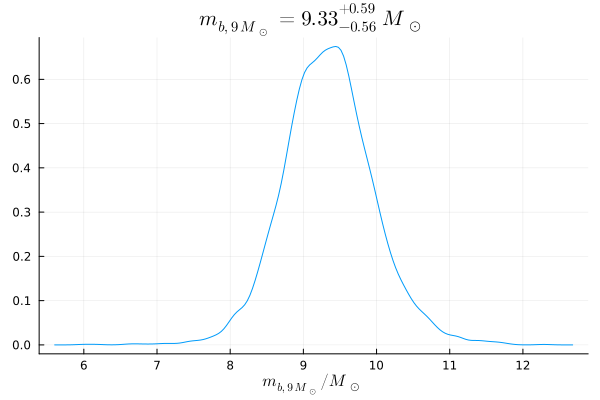

In [16]:
x = vec(mb_9)
title = @sprintf("\$m_{b,9\\,M_\\odot} = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", quantile(x, 0.5), quantile(x, 0.84) - quantile(x, 0.5), quantile(x, 0.5) - quantile(x, 0.16))
density(vec(x), xlabel=L"m_{b,9\,M_\odot} / M_\odot", label=nothing, title=title)

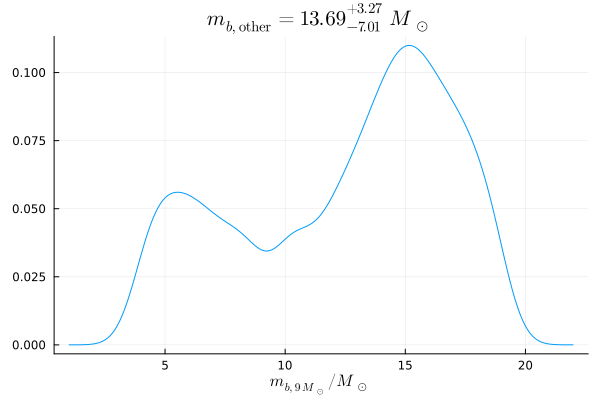

In [17]:
x = vec(mb_other)
title = @sprintf("\$m_{b,\\mathrm{other}} = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", quantile(x, 0.5), quantile(x, 0.84) - quantile(x, 0.5), quantile(x, 0.5) - quantile(x, 0.16))
density(vec(x), xlabel=L"m_{b,9\,M_\odot} / M_\odot", label=nothing, title=title)

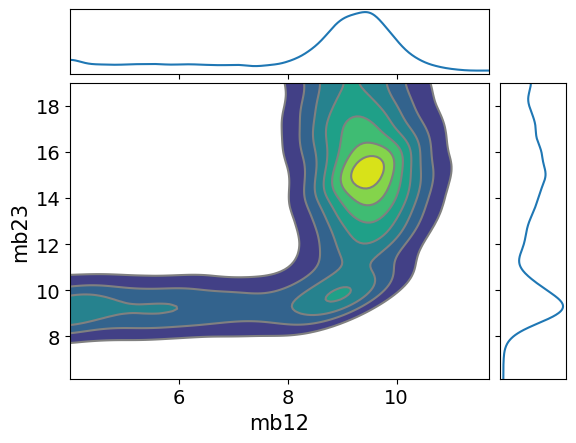

2×2 Matrix{PyCall.PyObject}:
 PyObject <Axes: >                              PyObject None
 PyObject <Axes: xlabel='mb12', ylabel='mb23'>  PyObject <Axes: >

In [18]:
plot_pair(trace, var_names=["mb12", "mb23"], marginals=true, kind="kde")

In [19]:
function m1pct(ms, f)
    fm = f.(ms)
    cfm = cumtrapz(ms, fm)

    ms[argmin(abs.(cfm/cfm[end] .- 0.01))]
end

m1pct (generic function with 1 method)

In [20]:
m1pct_m1 = map(dNdm1) do dN
    m1pct(ms, dN)
end
m1pct_m2 = map(dNdm2) do dN
    m1pct(ms, dN)
end
m1pct_pl = map(dNdm_pl) do dN
    m1pct(ms, dN)
end;

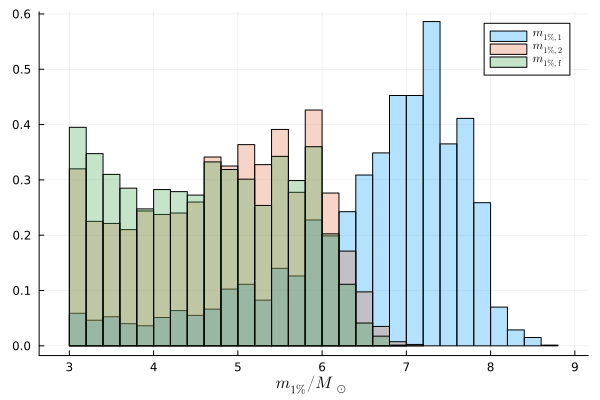

In [21]:
histogram(vec(m1pct_m1), label=L"m_{1\%,1}", xlabel=L"m_{1\%} / M_\odot", fillalpha=0.3, norm=:pdf)
histogram!(vec(m1pct_m2), label=L"m_{1\%,2}", fillalpha=0.3, norm=:pdf)
histogram!(vec(m1pct_pl), label=L"m_{1\%,\mathrm{f}}", fillalpha=0.3, norm=:pdf)

Let's do some model checking.  First, we plot the population-informed posteriors for $m_1$ and $m_2$:

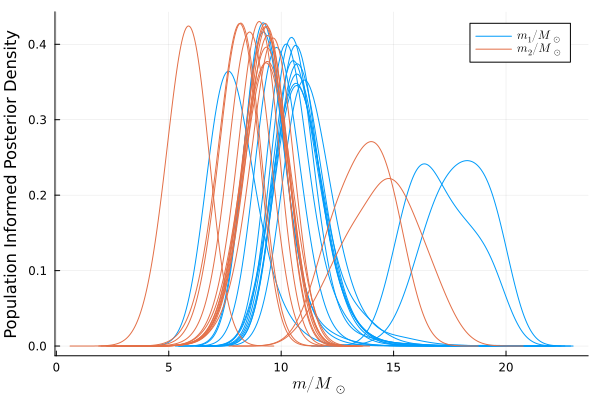

In [22]:
p = plot(xlabel=L"m / M_\odot", ylabel="Population Informed Posterior Density")
m1label = L"m_1 / M_\odot"
for n in DimensionalData.index(trace.posterior, :gwnames)
    p = density!(vec(trace.posterior.m1s_popwt[gwnames=At(n)]), color=1, label=m1label, bandwidth=0.75)
    m1label = nothing
end
m2label = L"m_2 / M_\odot"
for n in DimensionalData.index(trace.posterior, :gwnames)
    p = density!(vec(trace.posterior.m2s_popwt[gwnames=At(n)]), color=2, label=m2label, bandwidth=0.75)
    m2label = nothing
end
p

I bet our inference about the minimum BH mass is being driven by that one outlier.  Let's look:

In [23]:
nmin = ""
mmin = Inf
for n in DimensionalData.index(trace.posterior, :gwnames)
    mm = minimum(trace.posterior.m2s_popwt[gwnames=At(n)])

    if mm < mmin
        mmin = mm
        nmin = n
    end
    println("minimum($(n), m2): $(mm)")
end

minimum(GW190707_093326, m2): 6.065700574481275
minimum(GW190708_232457, m2): 10.676955710112418
minimum(GW190720_000836, m2): 6.356318592619994
minimum(GW190728_064510, m2): 5.897284339442792
minimum(GW190924_021846, m2): 3.6104318059722385
minimum(GW190930_133541, m2): 5.284367237158941
minimum(GW191103_012549, m2): 6.3304827003683215
minimum(GW191105_143521, m2): 5.214039188086879
minimum(GW191126_115259, m2): 5.840458665597454
minimum(GW191129_134029, m2): 4.990692561871216
minimum(GW191204_171526, m2): 6.19167219586017
minimum(GW191216_213338, m2): 5.549972808813319
minimum(GW200202_154313, m2): 4.886433944741291
minimum(GW200225_060421, m2): 10.848580379800463
minimum(GW200316_215756, m2): 6.142885172661345


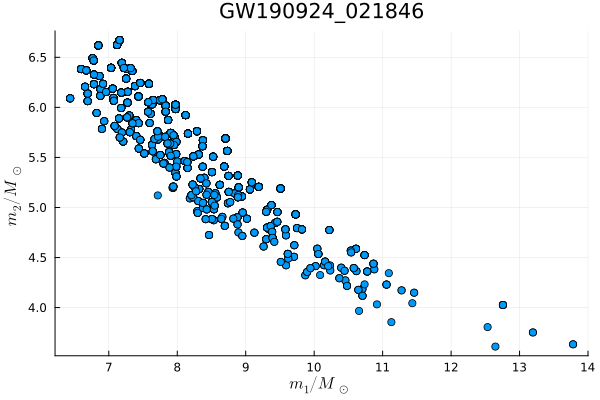

In [24]:
scatter(vec(trace.posterior.m1s_popwt[gwnames=At(nmin)]), vec(trace.posterior.m2s_popwt[gwnames=At(nmin)]), label=nothing, xlabel=L"m_1 / M_\odot", ylabel=L"m_2 / M_\odot", title=nmin)